In [73]:
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

Get Stock Data from Yahoo Finance

In [51]:
ticker = ["^GSPC"] # S&P 500

start_date = "2000-01-01"          
end_date   = "2025-01-01" 

temp = yf.download(ticker, start = start_date, end = end_date, group_by = "ticker")

GSPC = temp["^GSPC"].drop(['Volume'], axis = 1) # Volume not needed for any of the strategies 
GSPC = GSPC.dropna()

plt.style.use('dark_background')

[*********************100%***********************]  1 of 1 completed


# DCA

In [52]:
pd.set_option('display.float_format', '{:.2f}'.format)
monthly_investment = 1000

# Create a column with year-month information
GSPC['YearMonth'] = GSPC.index.to_period('M')

# Get unique months in the dataset
unique_months = GSPC['YearMonth'].unique()

# Create empty lists to store randomly selected data
random_dates = []
random_open_prices = []
random_close_prices = []

rng = np.random.RandomState(42) # So the results can be replicated

# For each month, select a random trading day
for month in unique_months:
    # Get all rows for this month
    month_data = GSPC[GSPC['YearMonth'] == month]
    
    # Select a random row
    random_row = month_data.sample(n = 1, random_state = rng)
    
    # Store the information
    random_dates.append(random_row.index[0])
    random_open_prices.append(random_row['Open'].iloc[0])
    random_close_prices.append(random_row['Close'].iloc[0])

# Create DataFrame with randomly selected data
monthly_trades = pd.DataFrame({'Date': random_dates, 'Open Price': random_open_prices,
                               'Close Price': random_close_prices})

# Set Date as index and sort chronologically
monthly_trades.set_index('Date', inplace = True)
monthly_trades.sort_index(inplace = True)

# Continue with the calculations
monthly_trades['Investment'] = monthly_investment
monthly_trades['Shares_Bought'] = monthly_trades['Investment'] / monthly_trades['Open Price']
monthly_trades['Cumul_Shares'] = monthly_trades['Shares_Bought'].cumsum()
monthly_trades['Cumul_Invested'] = monthly_trades['Investment'].cumsum()
monthly_trades['Portfolio Value'] = monthly_trades['Cumul_Shares'] * monthly_trades['Close Price']

monthly_trades.tail()

,Open Price,Close Price,Investment,Shares_Bought,Cumul_Shares,Cumul_Invested,Portfolio Value
Date,,,,,,,
2024-08-28,5624.51,5592.18,1000,0.18,185.16,296000,1035426.74
2024-09-19,5702.63,5713.64,1000,0.18,185.33,297000,1058917.73
2024-10-07,5737.80,5695.94,1000,0.17,185.51,298000,1056630.03
2024-11-01,5723.22,5728.80,1000,0.17,185.68,299000,1063726.70
2024-12-10,6057.59,6034.91,1000,0.17,185.85,300000,1121561.70


# Stats for DCA

In [53]:
# 1) Compute monthly returns on DCA portfolio value
df = monthly_trades.copy()
df['Monthly Return'] = df['Portfolio Value'].pct_change()

# 2) Total invested and final value
total_invested = df['Investment'].sum()
final_value = df['Portfolio Value'].iloc[-1]
total_return = (final_value - total_invested) / total_invested

# 3) CAGR (annualized growth rate)
days  = (df.index[-1] - df.index[0]).days
years = days / 365.25
cagr  = (final_value / total_invested)**(1 / years) - 1

# 4) Volatility & Sharpe Ratio (assume risk-free = 0)
monthly_vol    = df['Monthly Return'].std()
annual_vol     = monthly_vol * np.sqrt(12)
sharpe_ratio   = (df['Monthly Return'].mean() / monthly_vol) * np.sqrt(12)

# 5) Max Drawdown
running_max = df['Portfolio Value'].cummax()
drawdown    = (df['Portfolio Value'] - running_max) / running_max
max_drawdown = drawdown.min()

# 6) Best/Worst Month
best_month  = df['Monthly Return'].max()
worst_month = df['Monthly Return'].min()

# 7) Average Shares Bought per Month
avg_shares = df['Shares_Bought'].mean()

# 8) Assemble into a summary DataFrame
dca_stats = pd.DataFrame({'Metric': ['Total Invested ($)', 'Final Portfolio Value ($)', 'Total Return (%)', 'CAGR (%)',
                                     'Annual Volatility (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Best Month (%)',
                                     'Worst Month (%)', 'Avg Shares Bought'],
                          'Value': [round(total_invested, 2), round(final_value, 2), round(total_return * 100, 2),
                                    round(cagr * 100, 2), round(annual_vol * 100, 2), round(sharpe_ratio, 2),
                                    round(max_drawdown * 100, 2), round(best_month * 100, 2),
                                    round(worst_month * 100, 2), round(avg_shares, 4)]})

dca_stats

,Metric,Value
0,Total Invested ($),300000.00
1,Final Portfolio Value ($),1121561.70
2,Total Return (%),273.85
3,CAGR (%),5.43
4,Annual Volatility (%),30.00
5,Sharpe Ratio,1.07
6,Max Drawdown (%),-46.18
7,Best Month (%),96.24
8,Worst Month (%),-27.50
9,Avg Shares Bought,0.62


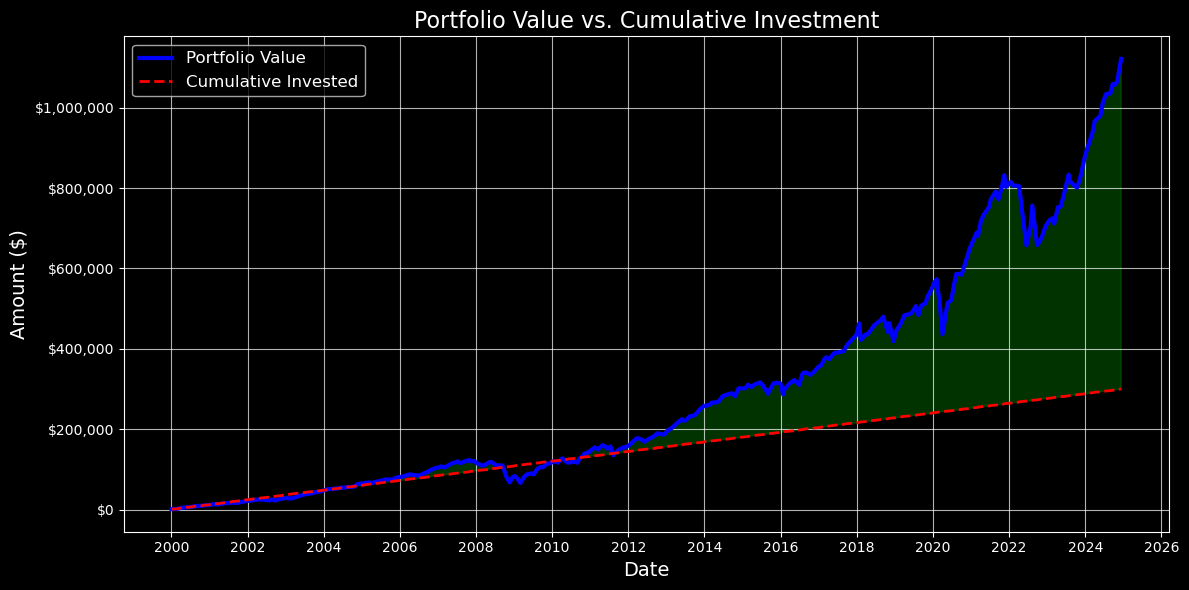

<Figure size 640x480 with 0 Axes>

In [54]:
# 1) Prepare the data
plot_data = monthly_trades[['Portfolio Value', 'Cumul_Invested']].copy()

# 2) Create the plot
plt.figure(figsize=(12, 6))

# Lines
plt.plot(plot_data.index, plot_data['Portfolio Value'], 'b', linewidth = 3, label='Portfolio Value')
plt.plot(plot_data.index, plot_data['Cumul_Invested'], 'r--', linewidth = 2, label='Cumulative Invested')

# Fill green where returns exceed invested capital
plt.fill_between(
    plot_data.index,
    plot_data['Cumul_Invested'],
    plot_data['Portfolio Value'],
    where = plot_data['Portfolio Value'] >= plot_data['Cumul_Invested'],
    color = 'green',
    alpha = 0.4
)

# Formatting
plt.title('Portfolio Value vs. Cumulative Investment', fontsize=16)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Amount ($)', fontsize = 14)

plt.grid(True, alpha = 0.7)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"${int(x):,}"))

plt.legend(loc = 'upper left', fontsize = 12)
plt.tight_layout()
plt.show()

plt.savefig('Portfolio Value vs. Cumulative Investment.png')

# SMA Crossover Strategy

In [55]:
# 1) Calculate moving averages
GSPC["SMA_50"] = GSPC['Close'].rolling(window = 50).mean()
GSPC["SMA_200"] = GSPC['Close'].rolling(window = 200).mean()

# 2) Generate crossing signals
GSPC['Signal'] = 0
GSPC.loc[GSPC['SMA_50'] > GSPC['SMA_200'], 'Signal'] = 1  # Long signal
GSPC.loc[GSPC['SMA_50'] < GSPC['SMA_200'], 'Signal'] = -1  # Short signal

# Find where signal changes
GSPC['Signal_Change'] = GSPC['Signal'].diff().ne(0)
crossing_dates = GSPC[GSPC['Signal_Change'] & (GSPC['Signal'] != 0)].index

# 3) Generate trading signals
signals = []
for date in crossing_dates:
    if GSPC.loc[date, 'Signal'] == 1:
        signals.append((GSPC.index.get_loc(date), 'long'))  # Golden cross
    else:
        signals.append((GSPC.index.get_loc(date), 'short'))  # Death cross

# 4) Backtest loop
initial_balance = 300000 
balance = initial_balance
equity_times = []
equity_values = []
trades = []

for j in range(len(signals) - 1):
    entry_id, position = signals[j]
    exit_id, _ = signals[j + 1]
    
    entry_price = GSPC['Close'].iloc[entry_id]
    exit_price = GSPC['Close'].iloc[exit_id]
    
    # Correct calculation for long and short returns
    if position == 'long':
        return_pct = (exit_price - entry_price) / entry_price
    else:  # Short position - corrected calculation
        return_pct = (entry_price - exit_price) / entry_price
    
    profit = balance * return_pct
    balance += profit
    
    equity_times.append(GSPC.index[exit_id])
    equity_values.append(balance)
    
    trades.append({'Entry Date': GSPC.index[entry_id],'Position': position, 'Entry Price': entry_price,
                   'Exit Date': GSPC.index[exit_id], 'Exit Price': exit_price, 'Return (%)': return_pct * 100,
                   'Balance After Trade': balance})

trades_df = pd.DataFrame(trades)
trades_df.head()

,Entry Date,Position,Entry Price,Exit Date,Exit Price,Return (%),Balance After Trade
0,2000-10-16,long,1374.62,2000-10-30,1398.66,1.75,305246.55
1,2000-10-30,short,1398.66,2003-05-14,939.28,32.84,405502.62
2,2003-05-14,long,939.28,2004-08-18,1095.17,16.60,472802.90
3,2004-08-18,short,1095.17,2004-11-05,1166.17,-6.48,442151.04
4,2004-11-05,long,1166.17,2006-07-19,1259.81,8.03,477654.46


# SMA Stats

In [67]:
# 1) Build an equity-curve DataFrame at your trade exits
sma_df = pd.DataFrame({'Equity': equity_values}, index = equity_times)
sma_df['Return'] = sma_df['Equity'].pct_change()

# 2) Basic P/L metrics
initial = initial_balance
final_value = sma_df['Equity'].iloc[-1]
total_return = (final_value - initial) / initial

# 3) CAGR
cagr = (final_value / initial) ** (1 / years) - 1

# 4) Volatility & Sharpe (rf=0)
period_std = sma_df['Return'].std()
annual_vol = period_std * np.sqrt(12)      # approximate monthly→annual
sharpe_ratio = (sma_df['Return'].mean() / period_std) * np.sqrt(12)

# 5) Max drawdown
running_max = sma_df['Equity'].cummax()
drawdowns = (sma_df['Equity'] - running_max) / running_max
max_drawdown = drawdowns.min()

# 6) Best / worst single-period returns
best_ret = sma_df['Return'].max()
worst_ret = sma_df['Return'].min()

# 7) Trade-level stats from trades_df
total_trades = len(trades_df)
wins = (trades_df['Return (%)'] > 0).sum()
losses = (trades_df['Return (%)'] <= 0).sum()
win_rate = wins / total_trades * 100
avg_trade_ret = trades_df['Return (%)'].mean()

# 8) Assemble into a DataFrame
sma_stats = pd.DataFrame({'Metric': ['Total Trades', 'Winning Trades', 'Losing Trades', 'Win Rate (%)',
                                     'Avg Return per Trade (%)','Total Return (%)', 'CAGR (%)',
                                     'Annual Volatility (%)', 'Sharpe Ratio','Max Drawdown (%)', 'Best Return (%)',
                                     'Worst Return (%)'],
                          'Value': [total_trades, wins, losses, round(win_rate, 2), round(avg_trade_ret, 2),
                                    round(total_return*100, 2), round(cagr*100, 2), round(annual_vol*100, 2),
                                    round(sharpe_ratio, 2), round(max_drawdown*100, 2), round(best_ret*100, 2),
                                    round(worst_ret*100, 2),]})

sma_stats

,Metric,Value
0,Total Trades,22.00
1,Winning Trades,10.00
2,Losing Trades,12.00
3,Win Rate (%),45.45
4,Avg Return per Trade (%),6.63
5,Total Return (%),284.02
6,CAGR (%),5.54
7,Annual Volatility (%),11.16
8,Sharpe Ratio,0.54
9,Max Drawdown (%),-25.15


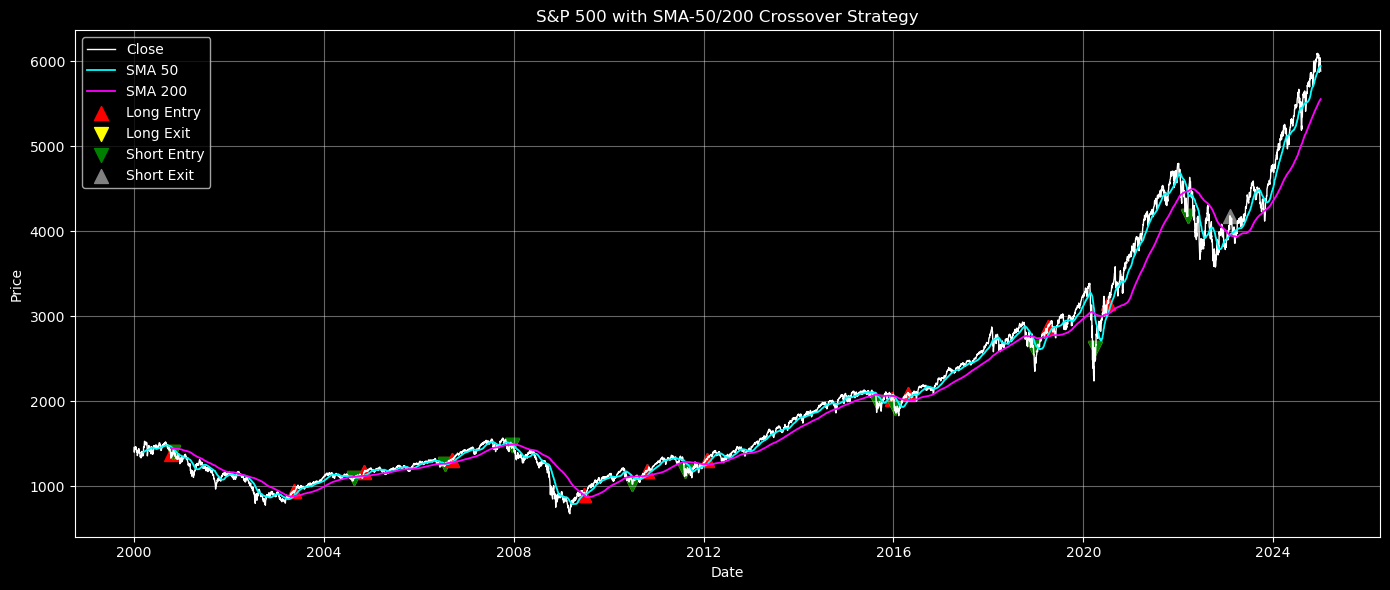

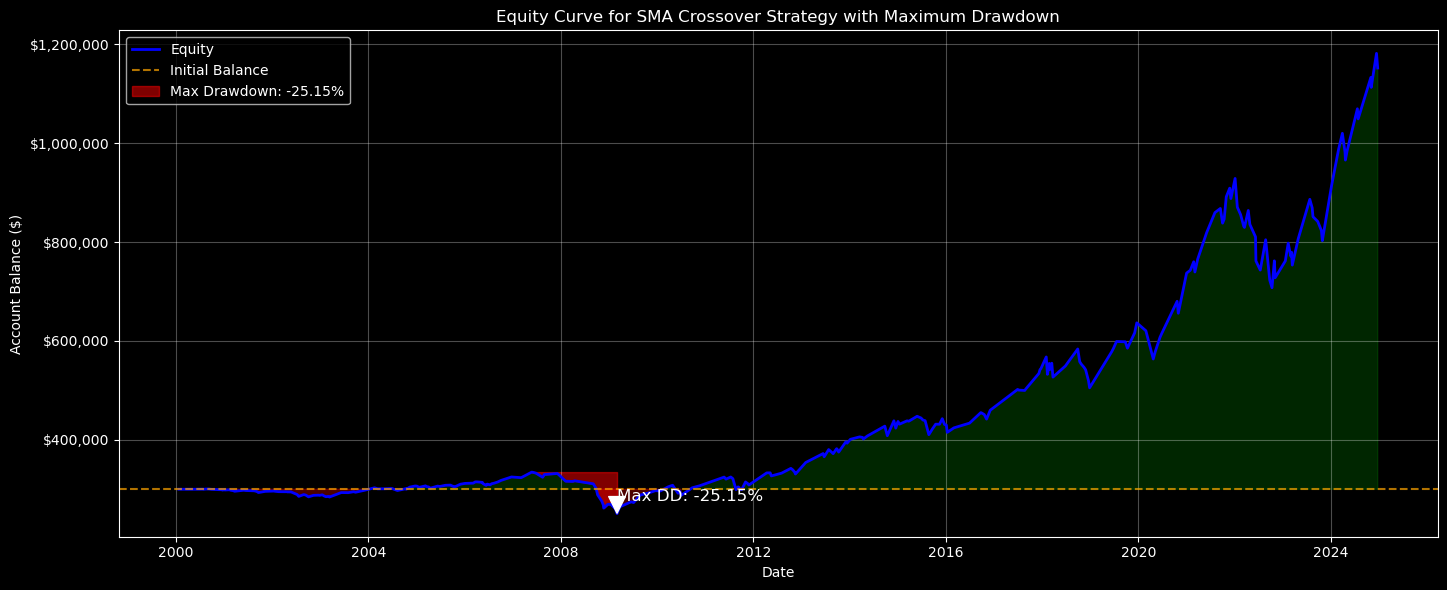

In [65]:
plt.figure(figsize = (14, 6))
# 1) Plot price and SMAs
plt.plot(GSPC.index, GSPC['Close'], label = 'Close', color = 'white', linewidth = 1)
plt.plot(GSPC.index, GSPC['SMA_50'], label = 'SMA 50', color = 'cyan', linewidth = 1.3)
plt.plot(GSPC.index, GSPC['SMA_200'], label = 'SMA 200', color = 'magenta', linewidth = 1.3)

# 2) Annotate each trade
for _, trade in trades_df.iterrows():  # Fixed the syntax error here
    entry_date = trade['Entry Date']
    exit_date = trade['Exit Date']
    entry_price = trade['Entry Price']
    exit_price = trade['Exit Price']
    position = trade['Position']
    
    # marker style
    if position == 'long':
        plt.scatter(entry_date, entry_price, marker = '^', color = 'red', s = 100, label = 'Long Entry')
        plt.scatter(exit_date, exit_price, marker = 'v', color = 'yellow', s = 100, label = 'Long Exit')
    else:
        plt.scatter(entry_date, entry_price, marker = 'v', color = 'green', s = 100, label = 'Short Entry')
        plt.scatter(exit_date, exit_price, marker = '^', color = 'grey', s = 100, label = 'Short Exit')

# 3) Clean up legend (avoid duplicate labels)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc = 'best')
plt.title('S&P 500 with SMA-50/200 Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True, alpha = 0.4)
plt.tight_layout()

# Calculate running maximum for equity curve
running_max_equity = np.maximum.accumulate(equity_values)
drawdown_percentages = (equity_values - running_max_equity) / running_max_equity * 100  # Convert to percentage
max_drawdown_percent = np.min(drawdown_percentages)
max_drawdown_index = np.argmin(drawdown_percentages)
drawdown_start_index = np.where(equity_values[:max_drawdown_index] == running_max_equity[max_drawdown_index])[0][-1]

# Create equity curve plot with drawdown highlight
plt.figure(figsize = (14, 6))
plt.plot(equity_times, equity_values, color = 'blue', linewidth = 2, label = 'Equity')
plt.axhline(y = initial_balance, color = 'orange', linestyle = '--', alpha = 0.7, label = 'Initial Balance')

# Fill profit/loss areas
plt.fill_between(equity_times, initial_balance, equity_values, where = (np.array(equity_values) >= initial_balance), 
                color = 'green', alpha = 0.3)
plt.fill_between(equity_times, initial_balance, equity_values, where = (np.array(equity_values) < initial_balance), 
                color = 'red', alpha = 0.3)

# Highlight the maximum drawdown period
plt.fill_between(equity_times[drawdown_start_index:max_drawdown_index + 1], 
                equity_values[drawdown_start_index:max_drawdown_index + 1], 
                running_max_equity[drawdown_start_index:max_drawdown_index + 1], 
                color = 'red', alpha = 0.5, label = f'Max Drawdown: {max_drawdown_percent:.2f}%')

# Annotate the max drawdown
plt.annotate(f'Max DD: {max_drawdown_percent:.2f}%',
             xy = (equity_times[max_drawdown_index], equity_values[max_drawdown_index]),
             xytext = (equity_times[max_drawdown_index], equity_values[max_drawdown_index] * 1.1),
             arrowprops = dict(facecolor = 'white', shrink = 0.05, width = 1.5),
             fontsize = 12)

plt.title('Equity Curve for SMA Crossover Strategy with Maximum Drawdown')
plt.xlabel('Date')
plt.ylabel('Account Balance ($)')
plt.legend(loc = 'upper left')
plt.grid(True, alpha = 0.3)
plt.tight_layout()

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"${int(x):,}"))

plt.show()

# Buy the dip Strategy

In [58]:
# In theory doing this strategy should lead to a greater ROI as your buying at disocunted price

# Works out how near the close price is to the 'low' price
 
GSPC['Range'] = GSPC.High - GSPC.Low
GSPC['Dist'] = abs(GSPC.Close - GSPC.Low)
GSPC['Relative_Close'] = (GSPC.Dist / GSPC.Range) * 100

dip_threshold = 25 

GSPC['Price_Dip'] = GSPC['Relative_Close'] <= dip_threshold

# https://stackoverflow.com/questions/27626542/counting-consecutive-positive-values-in-python-pandas-array
# To make sure we aren't buying on days were the price just dips randomly

GSPC['Dip_Streak'] = GSPC['Price_Dip'] * (GSPC['Price_Dip'].groupby((GSPC['Price_Dip'] 
                    != GSPC['Price_Dip'].shift()).cumsum()).cumcount() + 1)

# Check if there are 2 consecutive dips in price and buy on the 3rd day at open price

consec_threshold = 2

GSPC['Buy_Signal'] = GSPC['Dip_Streak'].shift(1) == consec_threshold

BD_initial_balance = 300000 # Using 300k as we invsted that same amount in the other models

# find buy days
BD_trades_df = (GSPC.loc[GSPC['Buy_Signal'], ['Open','Close']].rename(columns = {'Open':'Open Price',
                                                                                 'Close':'Close Price'}).copy())

# add bookkeeping cols
for col in ['Investment','Shares_Bought','Cumul_Shares','Cumul_Invested','Cash_Balance','Portfolio_Value']:
    BD_trades_df[col] = 0.0

# starting balances
cash = BD_initial_balance # 300_000
shares = 0.0
fixed_bet = 1000 # 1k each trade

# loop through each signal
for date, row in BD_trades_df.iterrows():
    # invest $1k or whatever remains if <1k
    invest = min(fixed_bet, cash)
    bought = invest / row['Open Price']
    
    # update cash & shares
    cash -= invest
    shares += bought
    
    # record
    BD_trades_df.at[date, 'Investment'] = invest
    BD_trades_df.at[date, 'Shares_Bought'] = bought
    BD_trades_df.at[date, 'Cumul_Shares'] = shares
    BD_trades_df.at[date, 'Cumul_Invested'] = BD_initial_balance - cash
    BD_trades_df.at[date, 'Cash_Balance'] = cash
    BD_trades_df.at[date, 'Portfolio_Value'] = shares * row['Close Price']

# 5) view resultsBD_trades_df.tail()


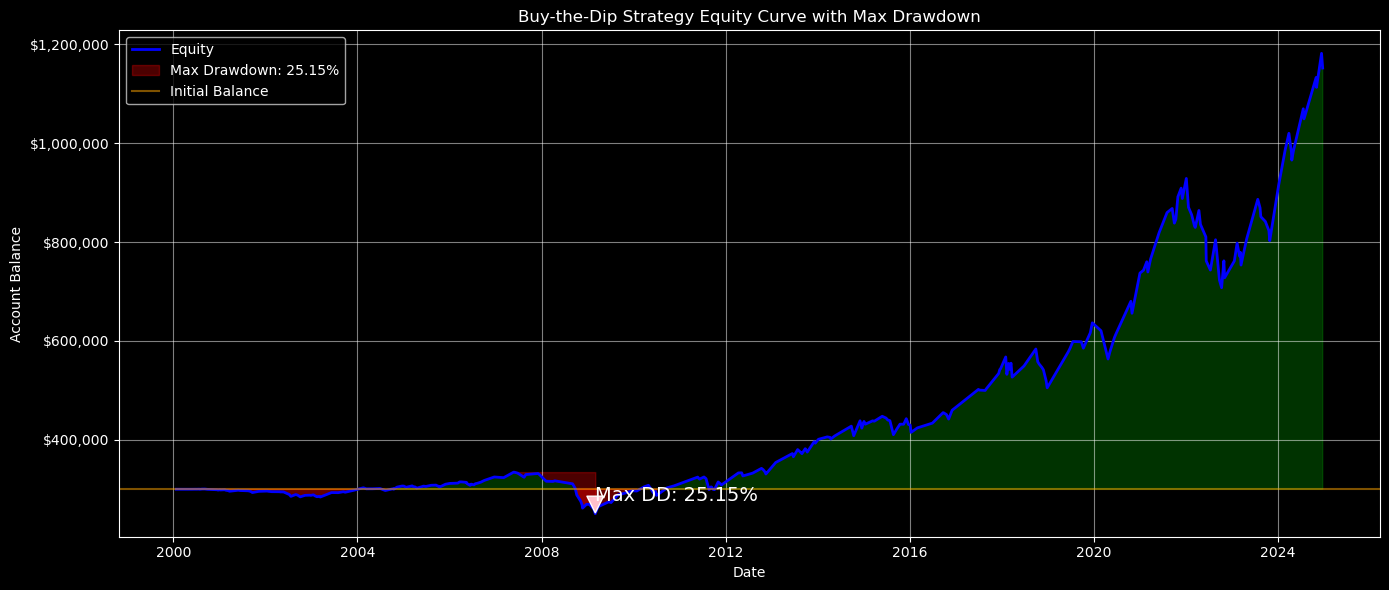

In [59]:
# 1) Compute total equity at each trade date
BD_trades_df['Equity'] = BD_trades_df['Cash_Balance'] + BD_trades_df['Portfolio_Value']

equity_times = BD_trades_df.index
equity_values = BD_trades_df['Equity'].values
initial_balance = BD_initial_balance

# 2) Running max & drawdowns
running_max_equity = np.maximum.accumulate(equity_values)
drawdowns = (equity_values - running_max_equity) / running_max_equity
max_dd_pct = drawdowns.min() * 100
max_dd_idx = int(np.argmin(drawdowns))
dd_start_idx = int(np.argmax(running_max_equity[:max_dd_idx + 1] == running_max_equity[:max_dd_idx + 1].max()))

# 3) Plot
plt.figure(figsize = (14,6))
# Equity curve and initial line
plt.plot(equity_times, equity_values, color = 'blue', linewidth = 2, label = 'Equity')

# Shade above/below initial
plt.fill_between(equity_times, initial_balance, equity_values,
                 where=(equity_values >= initial_balance), color = 'green', alpha = 0.4)
plt.fill_between(equity_times, initial_balance, equity_values,
                 where=(equity_values <  initial_balance), color = 'red',   alpha = 0.4)

# Highlight the worst drawdown segment
plt.fill_between(equity_times[dd_start_idx: max_dd_idx + 1], equity_values[dd_start_idx: max_dd_idx + 1],
                 running_max_equity[dd_start_idx:max_dd_idx+1], color='red', alpha = 0.3,
                 label = f'Max Drawdown: {abs(max_dd_pct):.2f}%')

# Annotate that point
plt.annotate(f'Max DD: {abs(max_dd_pct):.2f}%', xy = (equity_times[max_dd_idx], equity_values[max_dd_idx]),
             xytext = (equity_times[max_dd_idx], equity_values[max_dd_idx] * 1.1),
             arrowprops = dict(facecolor = 'pink', shrink = 0.1), fontsize = 14)

plt.axhline(y = initial_balance, color = 'orange', alpha = 0.5, label = 'Initial Balance')

# Labels, formatting, legend
plt.title('Buy-the-Dip Strategy Equity Curve with Max Drawdown')
plt.xlabel('Date')
plt.ylabel('Account Balance')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"${int(x):,}"))

plt.legend(loc = 'upper left')
plt.grid(True, alpha = 0.5)
plt.tight_layout()
plt.show()


# Overall Comparison

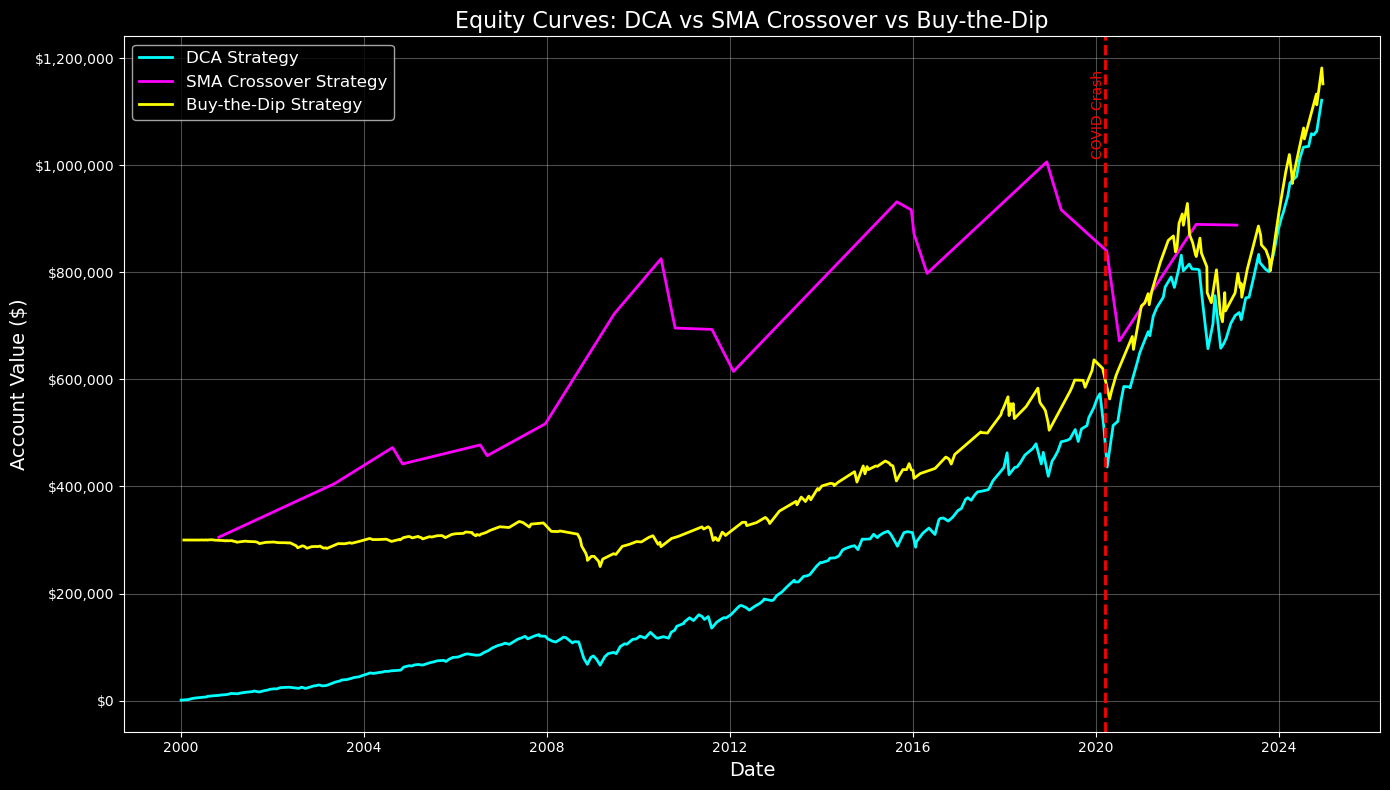

In [66]:
# Define event
covid = pd.to_datetime("2020-03-12")

plt.figure(figsize = (14, 8))

# Plot each strategy
plt.plot(monthly_trades.index, monthly_trades['Portfolio Value'], label = 'DCA Strategy', linewidth = 2,
         color = 'cyan')
plt.plot(sma_df.index, sma_df['Equity'], label = 'SMA Crossover Strategy', linewidth = 2, color = 'magenta')

plt.plot(BD_trades_df.index, BD_trades_df['Equity'], label = 'Buy-the-Dip Strategy', linewidth = 2, color = 'yellow')

# Annotate the COVID crash
plt.axvline(covid, color = 'red', linestyle = '--',linewidth = 2)

ylim = plt.gca().get_ylim()

plt.text(covid, ylim[1] * 0.95, "COVID Crash", color = 'red', rotation = 90, va = 'top', ha = 'right')

# Formatting
plt.title('Equity Curves: DCA vs SMA Crossover vs Buy-the-Dip', fontsize = 16)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Account Value ($)', fontsize = 14)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'${int(x):,}'))

plt.grid(alpha = 0.3)
plt.legend(loc = 'upper left', fontsize = 12)
plt.tight_layout()
plt.show()
